<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [84]:
import requests
from bs4 import BeautifulSoup
import json
from typing import Dict

%matplotlib inline

In [3]:
base_url = 'https://www.slf.ch/'
archive_parent = 'fr/bulletin-davalanches-et-situation-nivologique/archives.html?tx_wslavalanches_archiv%5Bpath%5D=%2Fuser_upload%2Fimport%2Flwdarchiv%2Fpublic%2F&tx_wslavalanches_archiv%5Baction%5D=showArchiv&tx_wslavalanches_archiv%5Bcontroller%5D=Avalanche&cHash=c71751a643ec4629e21b0306033ccd59'

In [4]:
def extract_folders(url: str) -> Dict[str, str]:
    html = requests.get(url)
    soup = BeautifulSoup(html.text, 'html.parser')
    folders = [folder.find('a') for folder in soup.findAll(class_='folder')]
    return {str(folder.contents[2]).split(',')[0].strip(): folder['href'] for folder in folders}

def extract_folders_rec(url: str, max_level: int = 3, curr_level: int = 0):
    full_url = base_url + url
    subfolders = extract_folders(full_url)
    if curr_level < max_level:
        for subfolder in subfolders:
            print('subfolder: {}'.format(subfolder))
            subfolder_url = subfolders[subfolder]
            subfolders[subfolder] = extract_folders_rec(subfolder_url, max_level, curr_level + 1)
    return subfolders

In [73]:
hierarchy = extract_folders_rec(archive_parent, max_level=4)

subfolder: Produits les plus récents
subfolder: 2018
subfolder: Bulletin d'avalanches
subfolder: de
subfolder: pdf
subfolder: en
subfolder: pdf
subfolder: fr
subfolder: pdf
subfolder: it
subfolder: pdf
subfolder: FR: Neuschnee 1 Tag
subfolder: de
subfolder: png
subfolder: pdf
subfolder: en
subfolder: png
subfolder: pdf
subfolder: fr
subfolder: png
subfolder: pdf
subfolder: it
subfolder: png
subfolder: pdf
subfolder: FR: Neuschnee 3 Tage
subfolder: de
subfolder: png
subfolder: pdf
subfolder: en
subfolder: png
subfolder: pdf
subfolder: fr
subfolder: png
subfolder: pdf
subfolder: it
subfolder: png
subfolder: pdf
subfolder: Cartes de neige
subfolder: de
subfolder: pdf
subfolder: gif
subfolder: en
subfolder: pdf
subfolder: gif
subfolder: fr
subfolder: pdf
subfolder: gif
subfolder: it
subfolder: pdf
subfolder: gif
subfolder: Enneigement à 2000 m
subfolder: de
subfolder: pdf
subfolder: gif
subfolder: en
subfolder: pdf
subfolder: gif
subfolder: fr
subfolder: pdf
subfolder: gif
subfolder: it
su

KeyboardInterrupt: 

In [30]:
a + timedelta(days=1)

def dates_between(start, stop):
    while start <= stop:
        yield start
        start += timedelta(days=1)
        
def hydrological_year(at_date):
    if at_date.month > 6:
        return at_date.year + 1
    else:
        return at_date.year
    

def danger_map_url(at_date):
    danger_map_pattern = 'https://www.slf.ch/fileadmin/user_upload/import/lwdarchiv/public/{}/nbk/de/gif/{}_nbk_de_c.gif'
    return danger_map_pattern.format(hydrological_year(at_date), at_date.strftime('%Y%m%d'))

files = list(danger_map_url(d) for d in dates_between(date(2002, 11, 14), date(2003, 5, 4)))

In [32]:
for d in dates_between(date(2002, 11, 14), date(2003, 5, 4)):
    url = danger_map_url(d)
    path = '../data/{}/danger/{}.gif'.format(hydrological_year(d), d.strftime('%Y%m%d'))
    res = requests.get(url)
    with open(path, 'wb') as f:
        f.write(res.content)

In [212]:
import numpy as np
from PIL import Image

black = [0, 0, 0, 255]
white = [255, 255, 255, 255]
green = [204, 255, 102, 255]
yellow = [255, 255, 0, 255]
orange = [255, 153, 0, 255]
red = [255, 0, 0, 255]

In [214]:
def keep_colors(img, colors, replace_with=(255,) * 4):
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[~keep] = replace_with
    return new_img

In [551]:
import cv2
from skimage import measure
from PIL import Image, ImageDraw

def numpies(o):
    if not isinstance(o, np.ndarray):
        o = np.array(o)
    return o

def color_contours(img, color):
    img = numpies(img)
    color = numpies(color)
    mask = (img == color[:3]).all(axis=-1)
    monocholor = img.copy()
    monocholor[~mask] = 255
    contours = measure.find_contours(mask, 0.5)
    
    # heuristic filter for contours
    filter_contours = []
    for c in contours:
        region = Image.new("L", [img.shape[1], img.shape[0]], 0)
        ImageDraw.Draw(region).polygon(list(map(lambda t: (t[1],t[0]), c)), fill=1)
        region = np.array(region).astype(bool)
        white_ratio = (monocholor == 255).all(axis=-1)[region].mean()
        if white_ratio <= .1:
            filter_contours.append(c)
    return filter_contours, monocholor


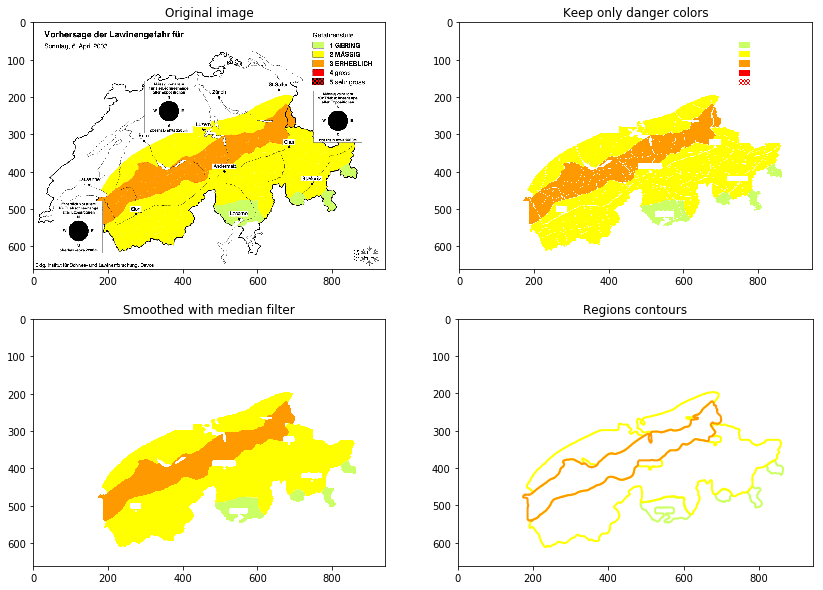

In [553]:
from pylab import contour
import matplotlib.pyplot as plt
from PIL import ImageFilter

fig, axes = plt.subplots(2, 2, figsize=(14,10))

path = '../data/danger/2003/20030405.gif'
img = Image.open(path)
img = img.convert('RGBA')
img_arr = np.array(img)
axes[0][0].imshow(img_arr);
axes[0][0].set_title('Original image');

regions_only = keep_colors(img_arr, [green, yellow, orange, red])
axes[0][1].imshow(regions_only);
axes[0][1].set_title('Keep only danger colors');

regions_only[50:200,740:790,:] = 255
regions_only = Image.fromarray(regions_only).convert('RGB')
smoothed = regions_only.filter(ImageFilter.MedianFilter(7))
axes[1][0].imshow(smoothed);
axes[1][0].set_title('Smoothed with median filter');


axes[1][1].set_xlim([0, img_arr.shape[1]])
axes[1][1].set_ylim([0, img_arr.shape[0]])
axes[1][1].invert_yaxis()
axes[1][1].set_title('Regions contours')
for color in [green, yellow, orange, red]:
    contours, _ = color_contours(smoothed, color)
    for contour in contours:
        axes[1][1].plot(contour[:, 1], contour[:, 0], linewidth=2, c=[x / 255 for x in color])
    